In [57]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(1337) # for reproducibility

def add_features(df):
    # features from phunter
    df['flight_dist_sig'] = df['FlightDistance']/df['FlightDistanceError']
    df['NEW_IP_dira'] = df['IP']*df['dira']
    df['p0p2_ip_ratio']=df['IP']/df['IP_p0p2']
    df['p1p2_ip_ratio']=df['IP']/df['IP_p1p2']
    df['DCA_MAX'] = df.loc[:, ['DOCAone', 'DOCAtwo', 'DOCAthree']].max(axis=1)
    df['iso_bdt_min'] = df.loc[:, ['p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT']].min(axis=1)
    df['iso_min'] = df.loc[:, ['isolationa', 'isolationb', 'isolationc','isolationd', 'isolatione', 'isolationf']].min(axis=1)
    # Stepan Obraztsov's magic features
    df['NEW_FD_SUMP'] = df['FlightDistance']/(df['p0_p']+df['p1_p']+df['p2_p'])
    df['NEW5_lt'] = df['LifeTime']*(df['p0_IP']+df['p1_IP']+df['p2_IP'])/3
    df['p_track_Chi2Dof_MAX'] = df.loc[:, ['p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof']].max(axis=1)
    # "super" feature from Grzegorz Sionkowski 
    df['NEW_FD_LT']=df['FlightDistance']/df['LifeTime']
    df['flight_dist_sig2'] = (df['FlightDistance']/df['FlightDistanceError'])**2
    return df

def load_data(data_file, output_y=True):
    df = pd.read_csv(data_file)
    df = add_features(df)
    if output_y:    # shuffle training set
        df = df.iloc[np.random.permutation(len(df))].reset_index(drop=True)
    filter_out = ['id', 'min_ANNmuon', 'production', 'mass', 'weight', 'signal']
    features = list(f for f in df.columns if f not in filter_out)
    return df[features].values, df['signal'].values if output_y else None, df['id']

def model_factory(n_inputs):
    model = Sequential()
    model.add(Dense(n_inputs, 800))
    model.add(PReLU((800,)))
    model.add(Dropout(0.5))
    model.add(Dense(800, 2))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return model
    
# load and preprocess data
X_train, y_train, _ = load_data("../input/training.csv")
X_test, _, id = load_data("../input/test.csv", output_y=False)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
y_train = np_utils.to_categorical(y_train)
X_test = scaler.transform(X_test)

# ensemble of single-layer neural nets
n_models = 1    # 5 or more models is better
n_epochs = 100   # must be increased to 120..150
probs = None
for i in range(n_models):
    print("\n----------- Keras: train Model %d/%d ----------\n" % (i+1,n_models))
    model = model_factory(X_train.shape[1])
    model.fit(X_train, y_train, batch_size=64, nb_epoch=n_epochs, validation_data=None, verbose=2, show_accuracy=True)
    p = model.predict(X_test, batch_size=256, verbose=0)[:, 1]
    probs = p if probs is None else probs + p
probs /= n_models

# forum idea of 'strong' + 'weak' classifier brought to extreme
# keep only strong predictions, substitute the other with noise
random_classifier = np.random.rand(len(probs))
q = 0.98
np.random.seed(1337) # for reproducibility
combined_probs = q * (probs ** 30) + (1 - q) * random_classifier
df = pd.DataFrame({"id": id, "prediction": combined_probs})
df.to_csv("submission.csv", index=False);

FileNotFoundError: File b'../input/training.csv' does not exist

In [2]:
import os

import numpy as np
import pandas as pd

from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import numpy

%matplotlib inline

In [3]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event( 'train_sample/train_100_events/' + event_prefix)

hits_sorted = hits.set_index('hit_id')
cells_sorted = cells.set_index('hit_id')

truth_sorted = truth.set_index('hit_id')
y  = truth_sorted['particle_id']


all_X = hits_sorted.join(cells_sorted)
all_data = all_X.join(y)
y = (all_data['particle_id'].values)

In [55]:
all_X_subsample = []
all_y_subsample = []
all_y_subsample_pid = []

i = 0
for p in np.unique(y)[:1000]:
    _particle_d = all_X.loc[all_data['particle_id'] == p ].values
    for dd in _particle_d:
        all_X_subsample.append( dd )    
        all_y_subsample.append( i  )
        all_y_subsample_pid.append(p)
    i += 1
all_X_subsample = numpy.array(all_X_subsample)
all_y_subsample = numpy.array(all_y_subsample)

scaler = StandardScaler().fit(all_X_subsample)

X_train, X_test, y_train, y_test = train_test_split(
            all_X_subsample, all_y_subsample, test_size=0.33, random_state=42)

In [27]:
y_train = np_utils.to_categorical(y_train)
y_train[0]

array([[[ 1.,  0.],
        [ 0.,  1.]],

       [[ 0.,  1.],
        [ 1.,  0.]],

       [[ 0.,  1.],
        [ 1.,  0.]],

       ..., 
       [[ 0.,  1.],
        [ 1.,  0.]],

       [[ 0.,  1.],
        [ 1.,  0.]],

       [[ 0.,  1.],
        [ 1.,  0.]]], dtype=float32)

In [30]:
y_train[0].shape

(500, 2, 2)

In [75]:
all_X_subsample = []
all_y_subsample = []
all_y_subsample_pid = []

i = 0
for p in np.unique(y)[1:1001]:
    _particle_d = all_X.loc[all_data['particle_id'] == p ].values
    for dd in _particle_d:
        all_X_subsample.append( dd )    
        all_y_subsample.append( i  )
        all_y_subsample_pid.append(p)
    i += 1
all_X_subsample = numpy.array(all_X_subsample)
all_y_subsample = numpy.array(all_y_subsample)

scaler = StandardScaler().fit(all_X_subsample)

X_train, X_test, y_train, y_test = train_test_split(
            all_X_subsample, all_y_subsample, test_size=0.33, random_state=42)



scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
y_train = np_utils.to_categorical(y_train)
X_test = scaler.transform(X_test)

# ensemble of single-layer neural nets
n_models = 1    # 5 or more models is better
n_epochs = 100   # must be increased to 120..150
probs = None
for i in range(n_models):
    print("\n----------- Keras: train Model %d/%d ----------\n" % (i+1,n_models))
    model = model_factory(X_train.shape[1])
    model.fit(X_train, y_train, batch_size=64, nb_epoch=n_epochs, validation_data=None, verbose=2)
    p = model.predict(X_test, batch_size=256, verbose=0)[:, 1]
    probs = p if probs is None else probs + p
probs /= n_models


----------- Keras: train Model 1/1 ----------



C:\Users\hiSun\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/100
 - 4s - loss: 6.4159
Epoch 2/100
 - 3s - loss: 5.7790
Epoch 3/100
 - 3s - loss: 5.6669
Epoch 4/100
 - 3s - loss: 5.7087
Epoch 5/100
 - 3s - loss: 5.7063
Epoch 6/100
 - 3s - loss: 5.6290
Epoch 7/100
 - 4s - loss: 5.5208
Epoch 8/100
 - 3s - loss: 5.4044
Epoch 9/100
 - 3s - loss: 5.2951
Epoch 10/100
 - 3s - loss: 5.1984
Epoch 11/100
 - 3s - loss: 5.0998
Epoch 12/100
 - 3s - loss: 5.0085
Epoch 13/100
 - 4s - loss: 4.9205
Epoch 14/100
 - 3s - loss: 4.8364
Epoch 15/100
 - 3s - loss: 4.7673
Epoch 16/100
 - 4s - loss: 4.7193
Epoch 17/100
 - 4s - loss: 4.6651
Epoch 18/100
 - 4s - loss: 4.6338
Epoch 19/100
 - 4s - loss: 4.5867
Epoch 20/100
 - 4s - loss: 4.5639
Epoch 21/100
 - 4s - loss: 4.5366
Epoch 22/100
 - 4s - loss: 4.5162
Epoch 23/100
 - 4s - loss: 4.5037
Epoch 24/100
 - 4s - loss: 4.4968
Epoch 25/100
 - 4s - loss: 4.4839
Epoch 26/100
 - 4s - loss: 4.4802
Epoch 27/100
 - 4s - loss: 4.4745
Epoch 28/100
 - 4s - loss: 4.4665
Epoch 29/100
 - 4s - loss: 4.4645
Epoch 30/100
 - 4s - lo

In [8]:
X_train.shape[1]

9

In [60]:
def model_factory(n_inputs):
    model = Sequential()
    model.add(Dense(16, input_dim= (n_inputs )) )
    model.add(PReLU())
    model.add(Dense(1000) )
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return model

In [26]:
X_train.shape[1]

9

In [41]:
probs.shape

(5107,)

In [81]:
y_pred = model.predict(X_train, batch_size=256, verbose=0)

In [64]:
answer.shape

(98909, 1000)

In [83]:
sklearn.metrics.accuracy_score(y_train, y_pred)

ValueError: Can't handle mix of multilabel-indicator and continuous-multioutput

In [68]:
import sklearn


In [85]:
y_pred.shape

(36305, 1000)

In [104]:
numpy.sum( (y_pred[0] - y_train[0])**2.0 ) 

0.80706108

In [105]:
result_accuracy = numpy.sum( (y_train - y_pred)**2.0 ,axis = 1)

In [106]:
result_accuracy.shape

(36305,)

(array([   354.,    424.,    717.,   1808.,   7182.,  19646.,   3376.,
          1349.,    628.,    821.]),
 array([ -9.98531580e-01,  -7.98682171e-01,  -5.98832762e-01,
         -3.98983353e-01,  -1.99133945e-01,   7.15464354e-04,
          2.00564873e-01,   4.00414282e-01,   6.00263691e-01,
          8.00113100e-01,   9.99962509e-01]),
 <a list of 10 Patch objects>)

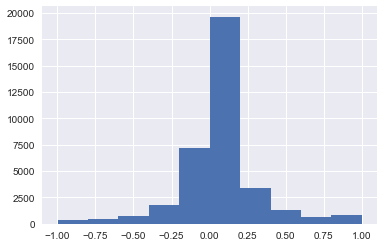

In [111]:
plt.hist(1.0 - result_accuracy)

In [108]:
import matplotlib.pyplot as plt

In [110]:
%matplotlib ipympl

ModuleNotFoundError: No module named 'ipympl'